In [1]:
from helpers.other_helpers import *
from helpers.viz_helpers import *
pd.set_option('display.float_format', '{:.2f}'.format)


In [2]:
s3 = s3_connection()
df = s3.get_tables_from_s3("aayrapetyan/diffusion/final_table.parquet")
df.sample(3)

connection successful


,total_voyageurs_2022,nom_gare,uic,codeinsee,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,...,psup2022,pagri2022,pindp2022,pcadr2022,ppint2022,pempl2022,pouvr2022,pchom2022,dist_closest_station_km,regions
2773,1723886,Vaucresson,87382267,92076,2.15,48.84,92076,VAUCRESSON,8766.00,50153.41,...,0.73,0.00,0.08,0.56,0.22,0.10,0.04,0.09,1.24,Île-de-France
2712,17490,Saint-Pierre-le-Moûtier,87696294,58264,3.11,46.79,58264,SAINT-PIERRE-LE-MOUTIER,1945.00,12681.81,...,0.20,0.05,0.00,0.04,0.38,0.34,0.19,0.06,8.56,Bourgogne-Franche-Comté
1603,56068,Saint-Étienne Le Clapier,87726174,42218,4.38,45.44,42218,SAINT-ETIENNE,174109.00,13644.66,...,0.31,0.00,0.07,0.16,0.26,0.28,0.24,0.11,1.23,Auvergne-Rhône-Alpes


In [3]:
df.describe().drop("count").drop(columns=["lon_gare", "lat_gare"]).round(2)

,total_voyageurs_2022,pop2022,revmoy2022,pbac2022,psup2022,pagri2022,pindp2022,pcadr2022,ppint2022,pempl2022,pouvr2022,pchom2022,dist_closest_station_km
mean,745465.89,18078.54,18221.52,0.46,0.29,0.01,0.07,0.14,0.26,0.29,0.23,0.07,4.86
std,3178484.88,50290.90,6608.60,0.13,0.13,0.04,0.06,0.11,0.11,0.11,0.12,0.05,3.73
min,1.00,55.00,5818.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12
25%,12938.50,1570.25,14922.08,0.37,0.20,0.00,0.04,0.07,0.21,0.23,0.14,0.04,2.22
50%,60333.50,4067.50,16931.46,0.45,0.28,0.00,0.06,0.12,0.26,0.29,0.22,0.07,3.82
75%,289815.25,12203.00,19639.30,0.54,0.37,0.01,0.09,0.19,0.31,0.35,0.30,0.10,6.27
max,102910589.00,875791.00,107572.81,1.00,1.00,0.58,0.67,0.82,0.92,1.00,1.00,0.48,30.39


In [4]:
aggregated_stats = calculate(
    df,
    group=["regions"],
    fields_stats_names=[
        ["total_voyageurs_2022", "sum"],
        ["pop2022", "sum"],
        ["revmoy2022", "mean"],
        ["pbac2022", "mean"],
        ["pagri2022", "mean"],
        ["pindp2022", "mean"],
        ["pcadr2022", "mean"],
        ["pempl2022", "mean"],
        ["pouvr2022", "mean"],
        ["pchom2022", "mean"],
        
    ],
)
df_for_map = df.merge(aggregated_stats, on="regions", how="inner")

In [31]:
df.regions.unique()

array(['Pays de la Loire', 'Île-de-France', 'Hauts-de-France',
       "Provence-Alpes-Côte d'Azur", 'Occitanie', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Centre-Val de Loire', 'Normandie',
       'Nouvelle-Aquitaine', 'Grand Est', 'Bretagne'], dtype=object)

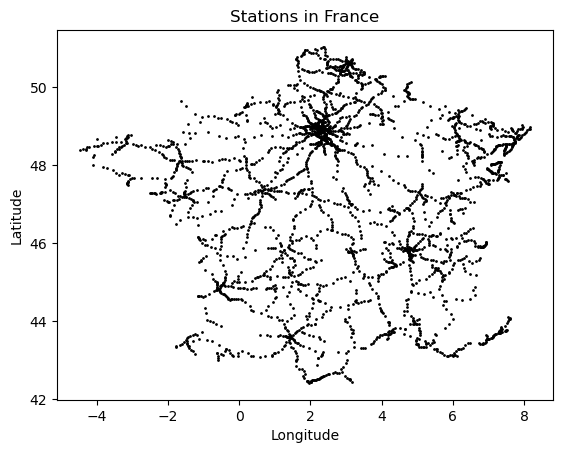

In [34]:
simple_plot_map(lat=df["lat_gare"], lon=df["lon_gare"])
idf=df[df["regions"]=="Île-de-France"]


nb removed observations :  18


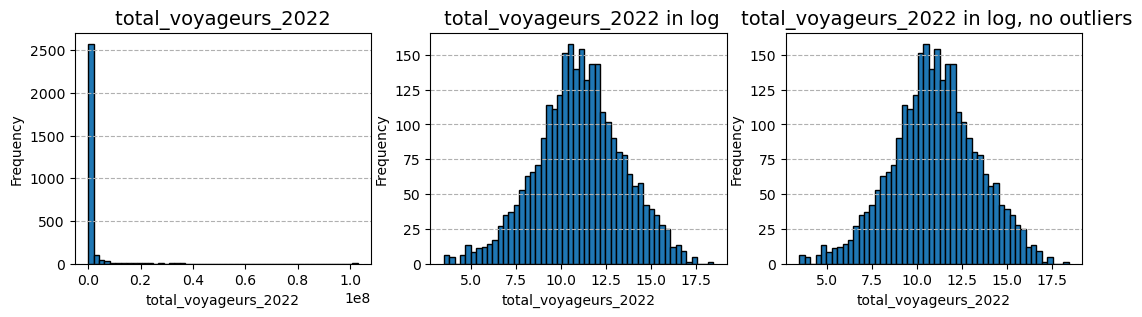

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # 3 rows, 1 column of plots
df = delete_outliers_z_score(df, np.log(df["total_voyageurs_2022"]))
df["total_voyageurs_2022_log"] =  np.log(df["total_voyageurs_2022"])
df["pop2022_log"] =  np.log(df["pop2022"])
df["pagri2022_log"] =  np.log(df["pagri2022"]+0.0001)
plot_hist(axs[0], df["total_voyageurs_2022"], title_suffix="")
plot_hist(axs[1], np.log(df["total_voyageurs_2022"]), title_suffix="in log")
plot_hist(
    axs[2],
    np.log(df["total_voyageurs_2022"]),
    title_suffix="in log, no outliers",
)

In [46]:
int(np.ceil(2 / 3))

1

In [37]:
7%3

1

In [59]:

def plot_square_map(lat,lon,fields_names,  figsize=(28, 28)):
    len_fields=len(fields_names)
    nb_axis=int(np.ceil(len_fields / 3))#i want 3 columns in every row
    fig, axs = plt.subplots(nb_axis, 3, figsize=figsize) 
    axs = axs.flatten()  # Flatten for easier iteration
    for idx, el in enumerate(fields_names):
        field = el[0]
        name = el[1]
        ax = axs[idx]  # Select the correct subplot
        #use another function
        plot_map_with_legend(
            ax,
            lon,
            lat,
            field,
            suffix_description=name,
        )
    #delete duplicated legends
    for ax in axs[len(fields_names):]:
        ax.axis("off") 
    plt.show()

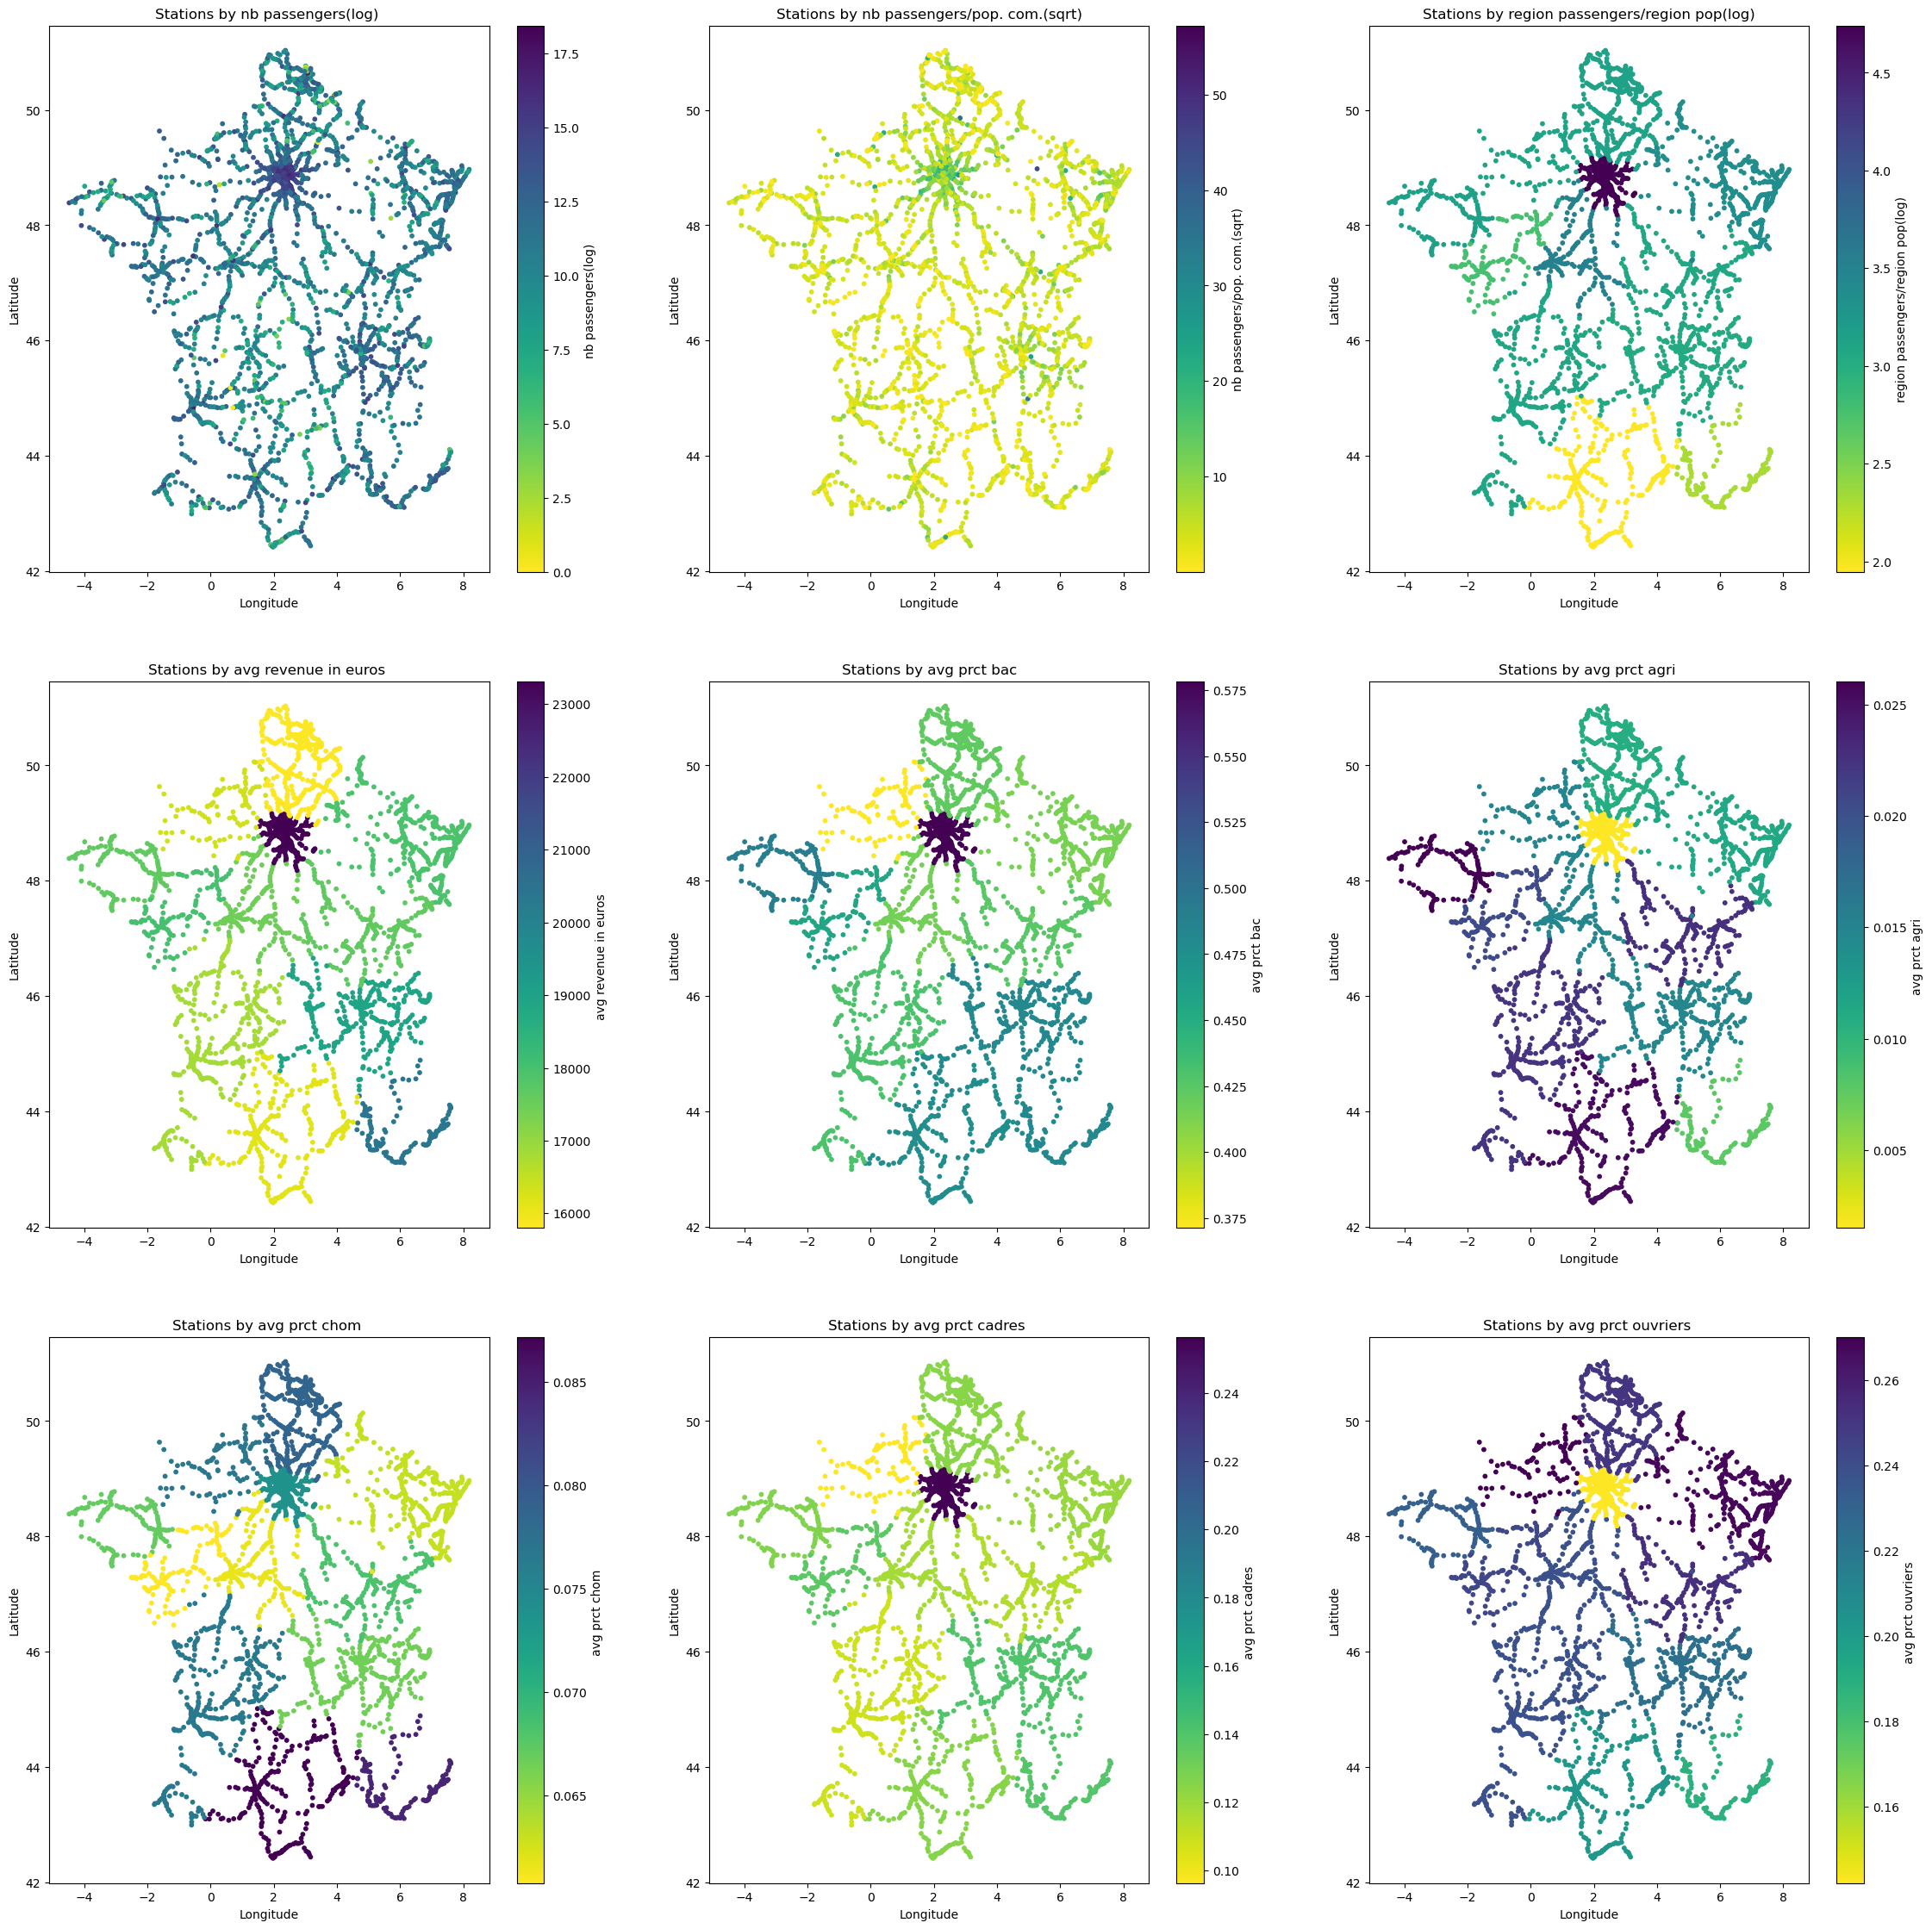

In [60]:
plot_square_map(lon=df_for_map["lon_gare"],lat=df_for_map["lat_gare"],
    fields_names=[
        [np.log(df_for_map["total_voyageurs_2022"]), "nb passengers(log) "],
        [
            np.sqrt(
                df_for_map["total_voyageurs_2022"] / df_for_map["pop2022"]
            ),
            "nb passengers/pop. com.(sqrt)",
        ],
        [
            np.log(
                df_for_map["total_voyageurs_2022_sum"]
                / df_for_map["pop2022_sum"]
            ),
            "region passengers/region pop(log)",
        ],
        [
            (df_for_map["revmoy2022_mean"]),
            "avg revenue in euros ",
        ],
        [
            df_for_map["pbac2022_mean"],
            "avg prct bac",
        ],
        [
            df_for_map["pagri2022_mean"],
            "avg prct agri ",
        ],
        [
            (df_for_map["pchom2022_mean"]),
            "avg prct chom ",
        ],
        [
            df_for_map["pcadr2022_mean"],
            "avg prct cadres ",
        ],
        [
            df_for_map["pouvr2022_mean"],
            "avg prct ouvriers ",
        ],
        
       
    ]
)

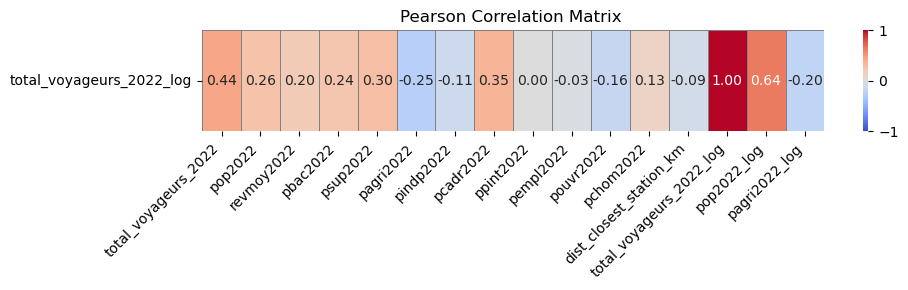

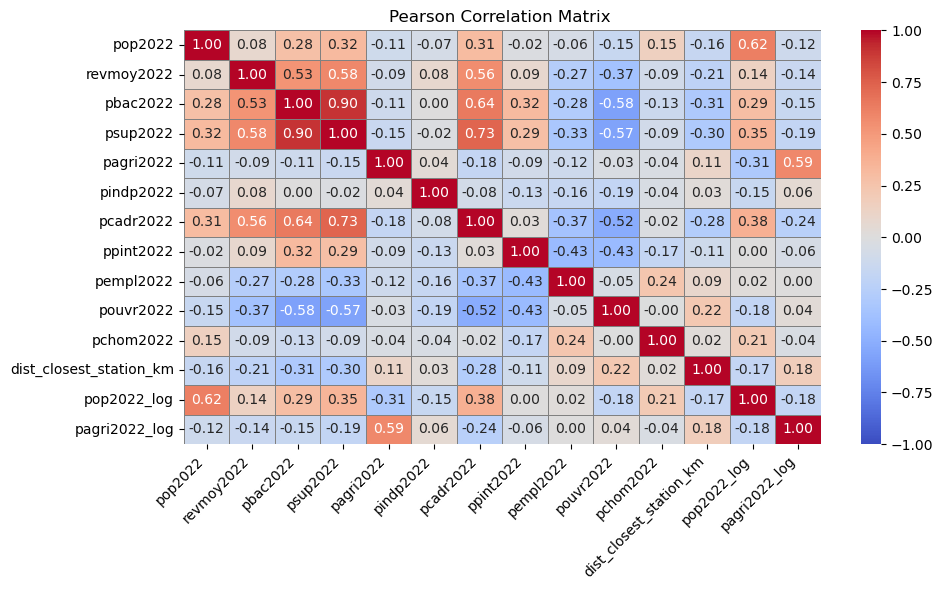

In [7]:
corr_matrix(df,filter_include=["total_voyageurs_2022_log"],filter_exclude=["lon_gare","lat_gare"],figsize=(10,3))
corr_matrix(df,filter_exclude=["total_voyageurs_2022_log","total_voyageurs_2022","lon_gare","lat_gare"])



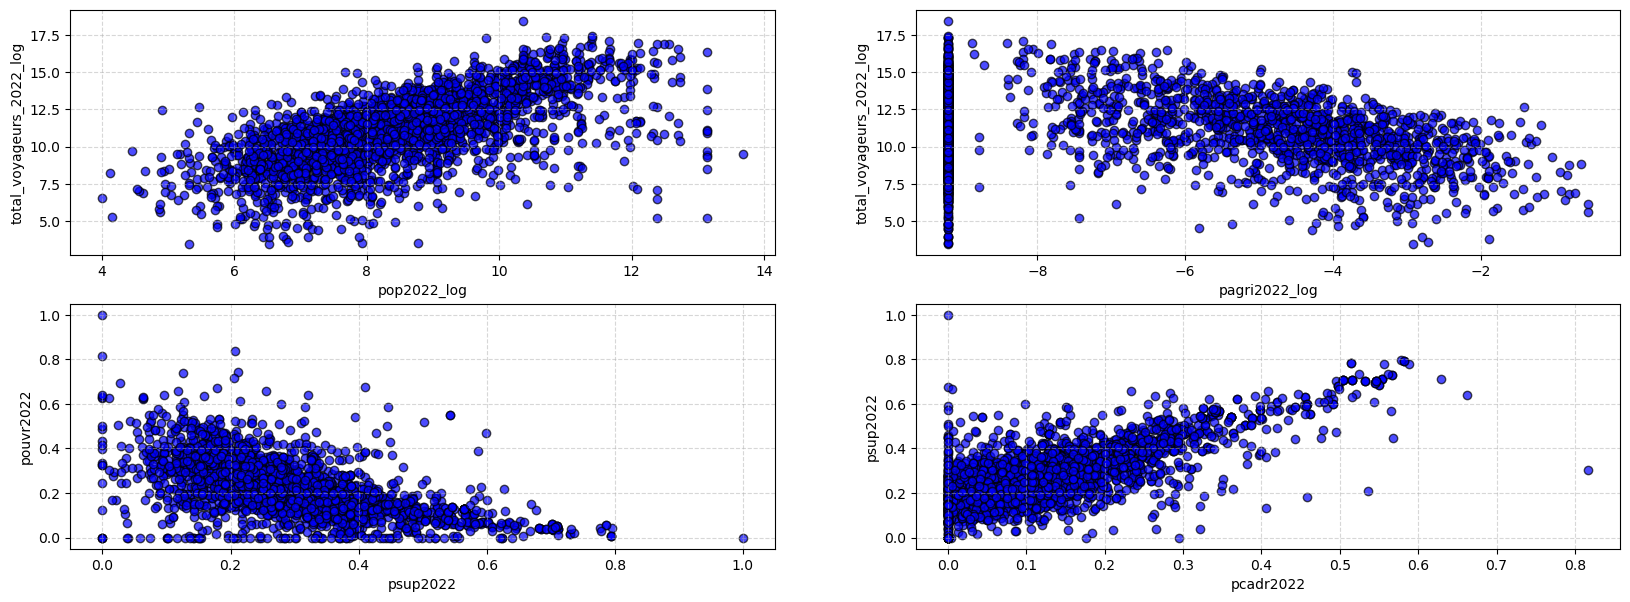

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(20, 7))  # Adjust figsize as needed

plot_scatter(
    ax=axs[0,0],
    x_series=(df['pop2022_log']),
    y_series=df['total_voyageurs_2022_log'],
    
    
)

plot_scatter(
    ax=axs[0,1],
    x_series=(df['pagri2022_log']),
    y_series=df['total_voyageurs_2022_log'],
    

)
plot_scatter(
    ax=axs[1,0],
    x_series=(df['psup2022']),
    y_series=df['pouvr2022'],  

)
plot_scatter(
    ax=axs[1,1],
    x_series=(df['pcadr2022']),
    y_series=df['psup2022'],  

)




now lets look at the correlation between continuos variable and categorical regional variable to see if statistically on the individual level it is nterestuing to include it to analysis

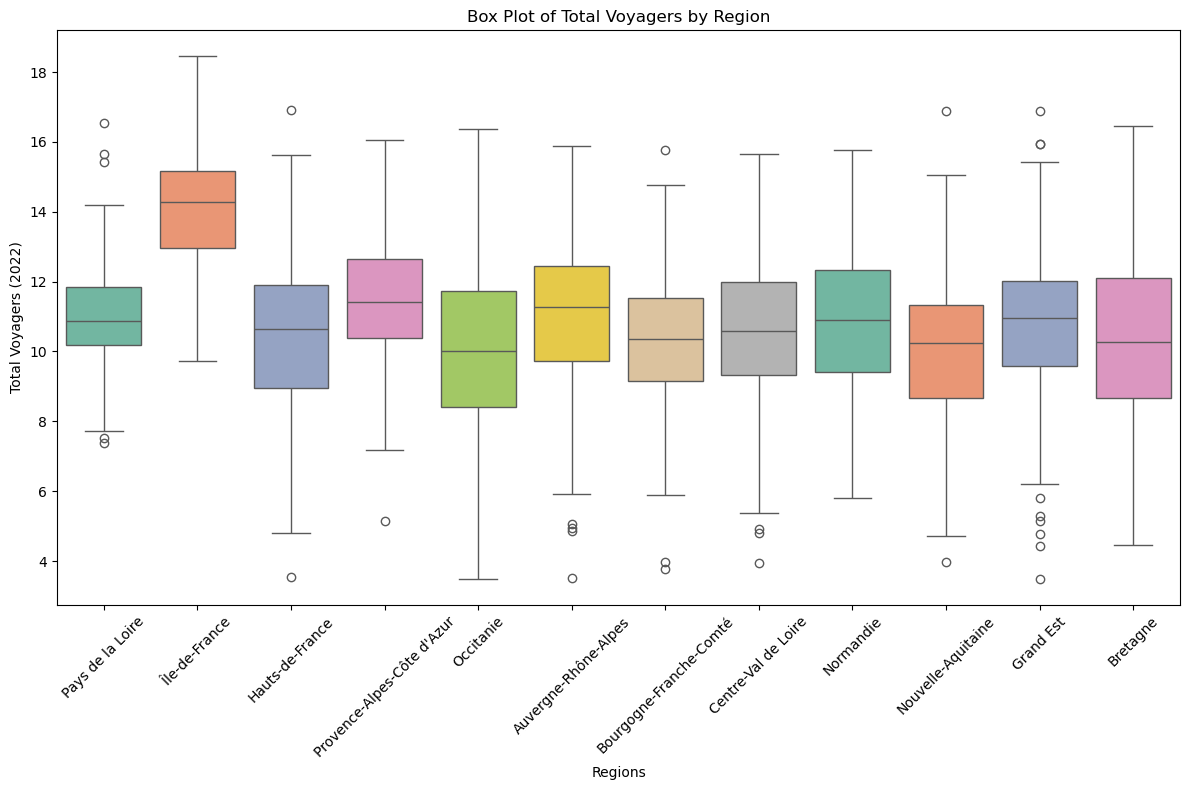

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Categorical variable = 'regions', Continuous variable = 'total_voyageurs_2022'

plt.figure(figsize=(12, 8))  # Adjust figure size
sns.boxplot(
    data=df,  
    x="regions"  ,               # Your DataFrame
    hue='regions', 
                  # Categorical variable
    y='total_voyageurs_2022_log',  # Continuous variable
    palette='Set2'   ,
    legend=False          # Optional: Color palette
)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
plt.title("Box Plot of Total Voyagers by Region")
plt.xlabel("Regions")
plt.ylabel("Total Voyagers (2022)")

plt.tight_layout()
plt.show()


In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

#filtrer par catégorie et extraire pour chaque catégorie le nb de voyageurs
groups = [table["total_voyageurs_2022_log"].values for region_filter, table in df.groupby("regions")]
#faire anova avec *, car c'est un requis de la fonction (args) 
f_stat, p_value = f_oneway(*groups)
print(f"P-value: {p_value:.4f}","Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.")



P-value: 0.0000 Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.


In [ ]:

 bonus aussi